<a href="https://colab.research.google.com/github/zvarellalee/ASCII-Parametric-Animation-Renderer/blob/main/Task_2_Improving_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
!pip install keras_tuner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import spacy
from spacy.lang.en import English
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words('english'))
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
import math
import re
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, Flatten, MaxPool1D, MaxPool2D, Conv2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.optimizers import Adam
from numpy import zeros

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import keras_tuner as kt

SEED = 42
random.seed(SEED)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 14.6 MB/s 
     |████████████████████████████████| 1.6 MB 60.7 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load Data

In [105]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-11-09 11:12:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-09 11:12:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-09 11:12:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#train_df = pd.read_csv('/content/drive/MyDrive/CZ4042/yelp_review_polarity_csv/train.csv', names = ['sentiment','review'])
#test_df = pd.read_csv('/content/drive/MyDrive/CZ4042/yelp_review_polarity_csv/test.csv', names = ['sentiment','review'])
df = pd.read_csv('/content/drive/MyDrive/CZ4042/IMDB Dataset.csv')

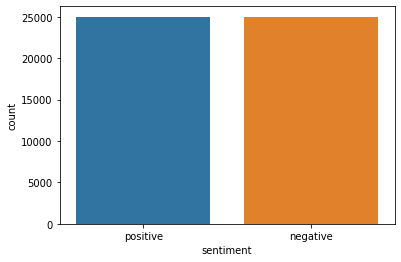

In [5]:
sns.countplot(df['sentiment'])

In [66]:
df_1 = df[:25000]
test_df = df[25000:]

In [67]:
# Return a list of indices
pos_idx = random.sample(list(df_1.query('sentiment=="positive"').index),1250)
neg_idx = random.sample(list(df_1.query('sentiment=="negative"').index),1250)

# Use indices to select data
df_sampled = df_1.loc[pos_idx + neg_idx]

In [68]:
df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)

In [69]:
df_sampled

,review,sentiment
0,I was a little skepticle if I should watch thi...,positive
1,"There is only one problem with this website, y...",negative
2,What an insult to the SA film industry! I have...,negative
3,Brilliant! My wife and I joined the sprawling ...,positive
4,"Having watched this movie several times, I hav...",negative
...,...,...
2495,I wasted 5 dollars renting this complete piece...,negative
2496,I missed the beginning but I did see most of i...,negative
2497,"Great softcore sex, revealing and sexy, and pl...",positive
2498,"I know I'm in the minority, but...<br /><br />...",negative


#Old

In [ ]:
train_df.head()

,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


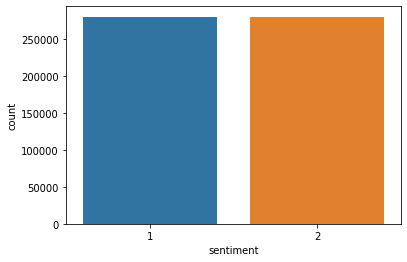

In [ ]:
sns.countplot(x = 'sentiment', data = train_df) #  Dataset is already balanced

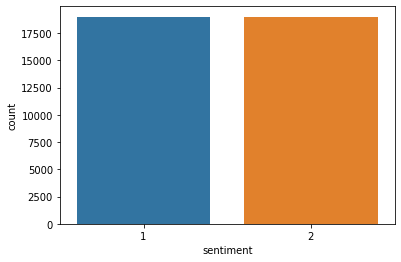

In [ ]:
sns.countplot(x = 'sentiment', data = test_df) #  Dataset is already balanced

# Data Augmentation

In [70]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [71]:
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [72]:
def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

In [73]:
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

In [74]:
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

In [144]:
def perform_augmentation(sentence,sentiment,alpha=0.1):
  sentence = get_only_chars(sentence)
  words = sentence.split(' ')
  words = [word for word in words if word is not '']
  num_words = len(words)
  num_replace = max(1, int(alpha*num_words))

  augmented_sentences = []
  
  for i in range(2):
    a_words = synonym_replacement(words, num_replace)
    augmented_sentences.append(' '.join(a_words))

    a_words = random_insertion(words, num_replace)
    augmented_sentences.append(' '.join(a_words))

    a_words = random_swap(words, num_replace)
    augmented_sentences.append(' '.join(a_words))

    a_words = random_deletion(words, alpha)
    augmented_sentences.append(' '.join(a_words))

  augmented_sentences = [(get_only_chars(sentence), sentiment) for sentence in augmented_sentences]
  augmented_sentences = shuffle(augmented_sentences)

  augmented_sentences.append((sentence, sentiment))

  return augmented_sentences

In [140]:
# split into train and test sets on the undersampled data.
train_df, val_df = train_test_split(df_sampled, test_size=0.5, random_state=SEED)

In [145]:
count = 0
total_augmented = []
for index, row in train_df.iterrows():
  total_augmented += perform_augmentation(row['review'], row['sentiment'])

print(len(total_augmented))

11250


In [146]:
total_augmented = shuffle(total_augmented)
train_df_augmented = pd.DataFrame(total_augmented, columns = ['review','sentiment'])
train_df_augmented.head()

,review,sentiment
0,first off id like to make a correction on anot...,positive
1,count laszlo ralph fiennes has just been trans...,positive
2,critters ranks as one of the greatest films of...,positive
3,pakeezah has very interesting history which is...,positive
4,this movie was one of a fistful that actually ...,negative


# Preprocessing

In [148]:
# preprocess function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # lower text
    text = text.lower()
    # Remove newline characters
    text = text.replace('\\n',' ').replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('\\', ' ')
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+',' ', text)
    # lemmatize
    #text = nlp(text)
    #text = [token.lemma_ for token in text]
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # tokenization done below, so no need to do it here.
    return text

In [ ]:
# apply preprocessing
#train_df['cleaned_review'] = train_df['review'].apply(preprocess_text)
#test_df['cleaned_review'] = test_df['review'].apply(preprocess_text)

In [149]:
train_df_augmented['cleaned_review'] = train_df_augmented['review'].apply(preprocess_text)
train_df['cleaned_review'] = train_df['review'].apply(preprocess_text)
val_df['cleaned_review'] = val_df['review'].apply(preprocess_text)
test_df['cleaned_review'] = test_df['review'].apply(preprocess_text)

In [150]:
train_df_augmented['sentiment'] = train_df_augmented['sentiment'].replace({'negative': 0, 'positive': 1})
train_df['sentiment'] = train_df['sentiment'].replace({'negative': 0, 'positive': 1})
val_df['sentiment'] = val_df['sentiment'].replace({'negative': 0, 'positive': 1})
test_df['sentiment'] = test_df['sentiment'].replace({'negative': 0, 'positive': 1})

In [ ]:
train_df['sentiment'] = train_df['sentiment'] - 1
test_df['sentiment'] = test_df['sentiment'] - 1

In [ ]:
train_df.head()

,sentiment,review,cleaned_review
0,0,"Unfortunately, the frustration of being Dr. Go...",unfortunately frustration dr goldberg patient ...
1,1,Been going to Dr. Goldberg for over 10 years. ...,going dr goldberg years think one st patients ...
2,0,I don't know what Dr. Goldberg was like before...,know dr goldberg like moving arizona let tell ...
3,0,I'm writing this review to give you a heads up...,writing review give heads see doctor office st...
4,1,All the food is great here. But the best thing...,food great best thing wings wings simply fanta...


# Vectorizing input

In [ ]:
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=SEED)

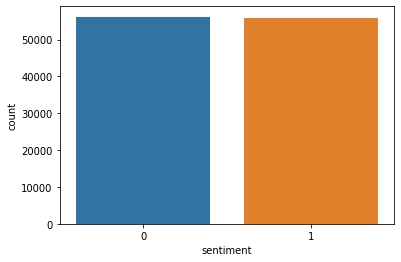

In [ ]:
sns.countplot(val_set['sentiment'])

In [168]:
test_df_resampled = test_df[:1000]

In [169]:
# tokenize cleaned_review column for both train_df and test_df
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
# fit our tokenizer on our training set, and apply it to the other sets
tokenizer.fit_on_texts(train_df['cleaned_review'])
maxLen = 100

X_train = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test = tokenizer.texts_to_sequences(test_df_resampled['cleaned_review'])
X_train = pad_sequences(X_train, padding='post', maxlen = maxLen)
X_val = pad_sequences(X_val, padding='post', maxlen = maxLen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxLen)

# y train/test
y_train = train_df['sentiment']
y_val = val_df['sentiment']
y_test = test_df_resampled['sentiment']

Use GloVe embeddings for feature matrix

In [170]:
vocab_size = len(tokenizer.word_index) + 1
def load_glove(word_index, embed_size):
    EMBEDDING_FILE = f'glove.6B.{embed_size}d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(EMBEDDING_FILE))
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = zeros((vocab_size, embed_size)) #np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        #if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [171]:
embed_size = 300
embedding_matrix = load_glove(tokenizer.word_index, embed_size)

In [172]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

19845


# CNN Model

In [173]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=maxLen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [174]:
print(cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          5953500   
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,145,757
Trainable params: 192,257
Non-trainable params: 5,953,500
_________________________________________________________________
None


In [175]:
# hyperparameters:
base_batch_size = 128
base_num_epochs = 5

cnn_model.fit(X_train, 
              y_train, 
              batch_size=base_batch_size, 
              epochs=base_num_epochs, 
              verbose=1, 
              validation_data=(X_val, y_val))

Epoch 1/5
10/10 [==============================] - 1s 35ms/step - loss: 0.7370 - acc: 0.5360 - val_loss: 0.6166 - val_acc: 0.6568
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.4555 - acc: 0.8584 - val_loss: 0.5481 - val_acc: 0.7440
Epoch 3/5
10/10 [==============================] - 0s 18ms/step - loss: 0.3416 - acc: 0.9408 - val_loss: 0.5384 - val_acc: 0.7288
Epoch 4/5
10/10 [==============================] - 0s 16ms/step - loss: 0.2711 - acc: 0.9696 - val_loss: 0.5016 - val_acc: 0.7696
Epoch 5/5
10/10 [==============================] - 0s 17ms/step - loss: 0.2140 - acc: 0.9904 - val_loss: 0.4832 - val_acc: 0.7768


32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       459
           1       0.83      0.73      0.78       541

    accuracy                           0.77      1000
   macro avg       0.78      0.78      0.77      1000
weighted avg       0.78      0.77      0.77      1000



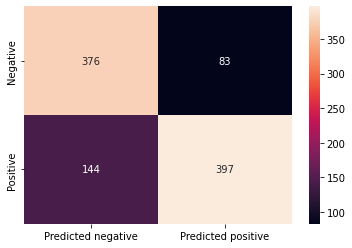

In [176]:
y_pred = (cnn_model.predict(X_test) > 0.5)*1 
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## With data augmentation

In [177]:
# tokenize cleaned_review column for both train_df and test_df
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
# fit our tokenizer on our training set, and apply it to the other sets
tokenizer.fit_on_texts(train_df_augmented['cleaned_review'])
maxLen = 100

X_train = tokenizer.texts_to_sequences(train_df_augmented['cleaned_review'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test = tokenizer.texts_to_sequences(test_df_resampled['cleaned_review'])
X_train = pad_sequences(X_train, padding='post', maxlen = maxLen)
X_val = pad_sequences(X_val, padding='post', maxlen = maxLen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxLen)

# y train/test
y_train = train_df_augmented['sentiment']
y_val = val_df['sentiment']
y_test = test_df_resampled['sentiment']

In [178]:
vocab_size = len(tokenizer.word_index) + 1
def load_glove(word_index, embed_size):
    EMBEDDING_FILE = f'glove.6B.{embed_size}d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(EMBEDDING_FILE))
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = zeros((vocab_size, embed_size)) #np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        #if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [179]:
embed_size = 300
embedding_matrix = load_glove(tokenizer.word_index, embed_size)

In [180]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

27939


In [232]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=maxLen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [182]:
print(cnn_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          8381700   
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,573,957
Trainable params: 192,257
Non-trainable params: 8,381,700
_________________________________________________________________
None


In [234]:
# hyperparameters:
base_batch_size = 128
base_num_epochs = 5

cnn_model.fit(X_train, 
              y_train, 
              batch_size=base_batch_size, 
              epochs=base_num_epochs, 
              verbose=1, 
              validation_data=(X_val, y_val))

Epoch 1/5
88/88 [==============================] - 2s 15ms/step - loss: 0.4682 - acc: 0.7988 - val_loss: 0.4488 - val_acc: 0.7824
Epoch 2/5
88/88 [==============================] - 1s 11ms/step - loss: 0.1654 - acc: 0.9788 - val_loss: 0.4160 - val_acc: 0.8128
Epoch 3/5
88/88 [==============================] - 1s 9ms/step - loss: 0.0727 - acc: 0.9986 - val_loss: 0.4259 - val_acc: 0.8088
Epoch 4/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0359 - acc: 1.0000 - val_loss: 0.4381 - val_acc: 0.8128
Epoch 5/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0203 - acc: 1.0000 - val_loss: 0.4647 - val_acc: 0.8048


32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       459
           1       0.81      0.87      0.84       541

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



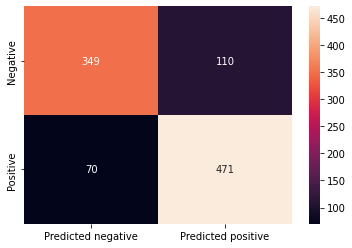

In [235]:
y_pred = (cnn_model.predict(X_test) > 0.5)*1 
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# BiLSTM

In [236]:
BILSTM_NEURONS = 50
DENSE_NEURONS = 50
DROPOUT_RATE = 0.5 # our data is imbalanced, so we want to counteract overfitting
LEARNING_RATE = 0.001
DECAY = 1e-6

# define the model
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxLen, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(BILSTM_NEURONS, return_sequences=True)))
model.add(Dropout(DROPOUT_RATE))
model.add(BatchNormalization())
#model.add(Bidirectional(CuDNNLSTM(BILSTM_NEURONS, return_sequences=True)))
#model.add(Dropout(DROPOUT_RATE))
#model.add(BatchNormalization())
#model.add(Bidirectional(CuDNNLSTM(BILSTM_NEURONS)))
#model.add(Dropout(DROPOUT_RATE))
#model.add(BatchNormalization())
#model.add(Flatten())                                    # TODO: may or may not need this
model.add(Dense(DENSE_NEURONS, activation='relu'))
model.add(Dense(DENSE_NEURONS, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,
                                                 decay=DECAY),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary(expand_nested=True))

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 100, 300)          8381700   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 100)         140400    
 l)                                                              
                                                                 
 dropout_9 (Dropout)         (None, 100, 100)          0         
                                                                 
 batch_normalization_11 (Bat  (None, 100, 100)         400       
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 100, 50)           5050      
                                                                 
 dense_37 (Dense)            (None, 100, 50)         

In [237]:
# Hyperparameters
NO_EPOCHS = 5
BATCH_SIZE = 128

# Fit train data
model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs = NO_EPOCHS,
          #verbose = 0,
          use_multiprocessing=True,
          validation_data=(X_val, y_val),
          )

Epoch 1/5
88/88 [==============================] - 7s 27ms/step - loss: 0.4981 - accuracy: 0.7365 - val_loss: 0.4470 - val_accuracy: 0.8160
Epoch 2/5
88/88 [==============================] - 2s 19ms/step - loss: 0.2177 - accuracy: 0.9107 - val_loss: 0.6372 - val_accuracy: 0.7168
Epoch 3/5
88/88 [==============================] - 2s 21ms/step - loss: 0.0942 - accuracy: 0.9651 - val_loss: 0.7048 - val_accuracy: 0.7944
Epoch 4/5
88/88 [==============================] - 2s 18ms/step - loss: 0.0366 - accuracy: 0.9873 - val_loss: 0.9537 - val_accuracy: 0.7832
Epoch 5/5
88/88 [==============================] - 2s 19ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 1.3977 - val_accuracy: 0.7824


32/32 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.84      0.72      0.77       459
           1       0.79      0.88      0.83       541

    accuracy                           0.81      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.81      0.80      1000



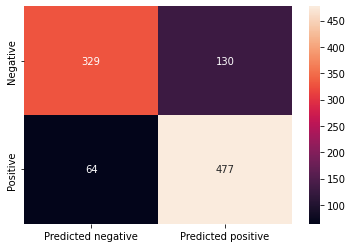

In [238]:
y_pred = (model.predict(X_test) > 0.5)*1 
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Tuning CNN Model

## Preprocessing

For the model tuning, we will use the full dataset.

In [310]:
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [320]:
df['sentiment'] = df['sentiment'].replace({'negative': 0, 'positive': 1})

In [321]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=SEED)
train_set, val_set = train_test_split(train_set, test_size=0.25, random_state=SEED)

# final proportions: train set = 0.6, val set = 0.2, test set = 0.2

In [322]:
# tokenize cleaned_review column for both train_df and test_df
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
# fit our tokenizer on our training set, and apply it to the other sets
tokenizer.fit_on_texts(train_set['cleaned_review'])
maxLen = 100

X_train = tokenizer.texts_to_sequences(train_set['cleaned_review'])
X_val = tokenizer.texts_to_sequences(val_set['cleaned_review'])
X_test = tokenizer.texts_to_sequences(test_set['cleaned_review'])
X_train = pad_sequences(X_train, padding='post', maxlen = maxLen)
X_val = pad_sequences(X_val, padding='post', maxlen = maxLen)
X_test = pad_sequences(X_test, padding='post', maxlen = maxLen)

# y train/test
y_train = train_set['sentiment']
y_val = val_set['sentiment']
y_test = test_set['sentiment']

In [323]:
vocab_size = len(tokenizer.word_index) + 1
def load_glove(word_index, embed_size):
    EMBEDDING_FILE = f'glove.6B.{embed_size}d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in   open(EMBEDDING_FILE))
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = zeros((vocab_size, embed_size)) #np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        #if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [324]:
embed_size = 300
embedding_matrix = load_glove(tokenizer.word_index, embed_size)

In [325]:
vocab_size = len(tokenizer.word_index) + 1

## Model function

In [326]:
def get_model(num_filters, filter_size, activation, optimizer=Adam()):
  model = Sequential()

  embedding_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=maxLen , trainable=False)
  model.add(embedding_layer)

  model.add(Conv1D(num_filters, filter_size, activation=activation))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  return model

In [327]:
def line_plot(lines, title, ylabel, xlabel):
  plt.plot(lines)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend([32,64,128,256,512], loc='bottom right')
  plt.show()

## Experiment 1: Varying the number of filters

In [328]:
filter_nums = [32,64,128,256,512]
filter_size = 5
activation = 'relu'
base_batch_size = 128
base_num_epochs = 5

train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_score = []

for num_filters in filter_nums:
  test_model = get_model(num_filters, filter_size, activation)
  history = test_model.fit(X_train, 
              y_train, 
              batch_size=base_batch_size, 
              epochs=base_num_epochs, 
              verbose=0, 
              validation_data=(X_val, y_val))
  train_acc.append(history.history['acc'])
  train_loss.append(history.history['loss'])
  val_acc.append(history.history['val_acc'])
  val_loss.append(history.history['val_loss'])

  score, acc = test_model.evaluate(X_test, y_test)
  test_acc.append(acc)
  test_score.append(score)

313/313 [==============================] - 1s 3ms/step - loss: 0.3576 - acc: 0.8730


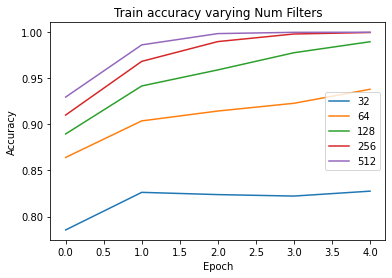

In [329]:
plt.plot(train_acc)
plt.title("Train accuracy varying Num Filters")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend([32,64,128,256,512], loc='bottom right')
plt.show()

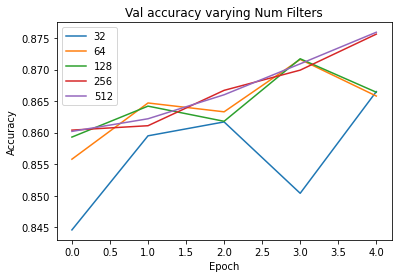

In [330]:
plt.plot(val_acc)
plt.title("Val accuracy varying Num Filters")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend([32,64,128,256,512], loc='bottom right')
plt.show()

(0.7, 0.9)

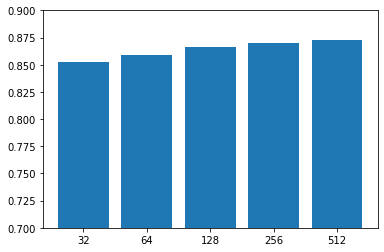

In [331]:
plt.bar(['32','64','128','256','512'], test_acc)
plt.ylim(0.7,0.9)

## Experiment 2: Varying the filter size

In [332]:
num_filters = 512
filter_sizes = [1,3,5,7]
activation = 'relu'
base_batch_size = 128
base_num_epochs = 5

train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_score = []

for filter_size in filter_sizes:
  test_model = get_model(num_filters, filter_size, activation)
  history = test_model.fit(X_train, 
              y_train, 
              batch_size=base_batch_size, 
              epochs=base_num_epochs, 
              verbose=0, 
              validation_data=(X_val, y_val))
  train_acc.append(history.history['acc'])
  train_loss.append(history.history['loss'])
  val_acc.append(history.history['val_acc'])
  val_loss.append(history.history['val_loss'])

  score, acc = test_model.evaluate(X_test, y_test)
  test_acc.append(acc)
  test_score.append(score)

313/313 [==============================] - 1s 3ms/step - loss: 0.3914 - acc: 0.8660


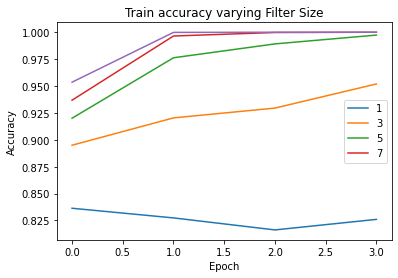

In [333]:
plt.plot(train_acc)
plt.title("Train accuracy varying Filter Size")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(filter_sizes, loc='bottom right')
plt.show()

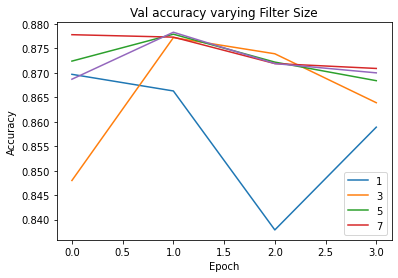

In [334]:
plt.plot(val_acc)
plt.title("Val accuracy varying Filter Size")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(filter_sizes, loc='bottom right')
plt.show()

(0.7, 0.9)

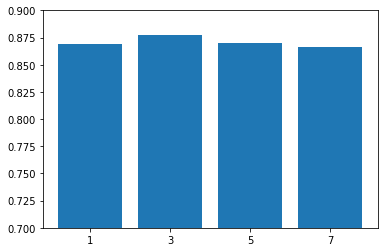

In [335]:
plt.bar(['1','3','5','7'], test_acc)
plt.ylim(0.7,0.9)

In [336]:
test_acc

[0.8689000010490417,
 0.8770999908447266,
 0.8701000213623047,
 0.8659999966621399]

## Experiment 3: Varying Learning Rate

In [337]:
num_filters = 512
filter_size = 5
activation = 'relu'
base_batch_size = 128
base_num_epochs = 5
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05]

train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_score = []

for lr in learning_rates:
  test_model = get_model(num_filters, filter_size, activation, optimizer=Adam(lr))
  history = test_model.fit(X_train, 
              y_train, 
              batch_size=base_batch_size, 
              epochs=base_num_epochs, 
              verbose=0, 
              validation_data=(X_val, y_val))
  train_acc.append(history.history['acc'])
  train_loss.append(history.history['loss'])
  val_acc.append(history.history['val_acc'])
  val_loss.append(history.history['val_loss'])

  score, acc = test_model.evaluate(X_test, y_test)
  test_acc.append(acc)
  test_score.append(score)

313/313 [==============================] - 1s 4ms/step - loss: 1.2716 - acc: 0.7851


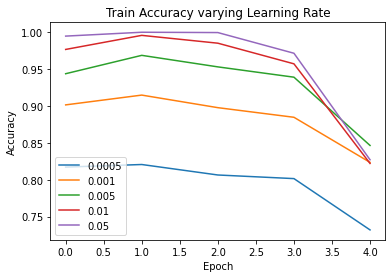

In [338]:
plt.plot(train_acc)
plt.title("Train Accuracy varying Learning Rate")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(learning_rates, loc='bottom right')
plt.show()

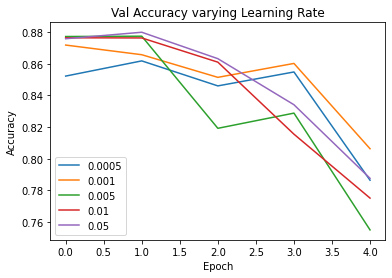

In [339]:
plt.plot(val_acc)
plt.title("Val Accuracy varying Learning Rate")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(learning_rates, loc='bottom right')
plt.show()

(0.7, 0.9)

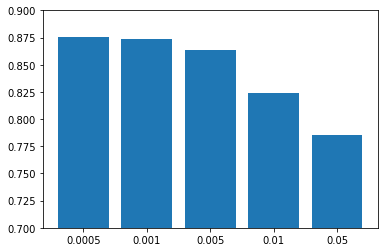

In [340]:
plt.bar([str(i) for i in learning_rates], test_acc)
plt.ylim(0.7,0.9)

In [341]:
test_acc

[0.8754000067710876,
 0.8741000294685364,
 0.8632000088691711,
 0.8241000175476074,
 0.785099983215332]

## Experiment 4: Varying batch size

In [342]:
num_filters = 512
filter_size = 5
activation = 'relu'
batch_sizes = [1,16,32,64,128,256,512]
base_num_epochs = 5
lr = 0.005

train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_score = []

for batch_size in batch_sizes:
  test_model = get_model(num_filters, filter_size, activation, optimizer=Adam(lr))
  history = test_model.fit(X_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=base_num_epochs, 
              verbose=0, 
              validation_data=(X_val, y_val))
  train_acc.append(history.history['acc'])
  train_loss.append(history.history['loss'])
  val_acc.append(history.history['val_acc'])
  val_loss.append(history.history['val_loss'])

  score, acc = test_model.evaluate(X_test, y_test)
  test_acc.append(acc)
  test_score.append(score)

313/313 [==============================] - 1s 4ms/step - loss: 0.3419 - acc: 0.8659


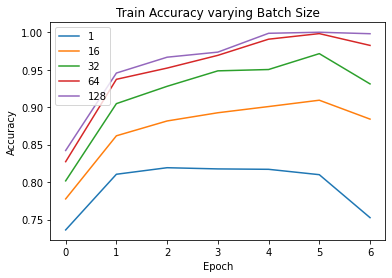

In [343]:
plt.plot(train_acc)
plt.title("Train Accuracy varying Batch Size")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(batch_sizes, loc='bottom right')
plt.show()

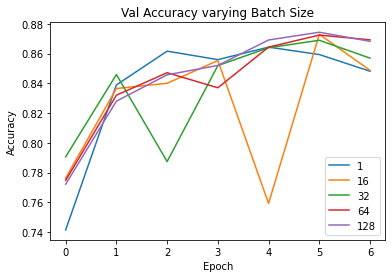

In [344]:
plt.plot(val_acc)
plt.title("Val Accuracy varying Batch Size")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(batch_sizes, loc='bottom right')
plt.show()

(0.7, 0.9)

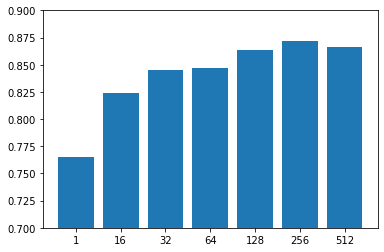

In [345]:
plt.bar([str(i) for i in batch_sizes], test_acc)
plt.ylim(0.7,0.9)

In [346]:
test_acc

[0.7648000121116638,
 0.8242999911308289,
 0.8450999855995178,
 0.8471999764442444,
 0.8636000156402588,
 0.8722000122070312,
 0.8658999800682068]

## Experiment 5: Varying num epochs

In [347]:
num_filters = 512
filter_size = 5
activation = 'relu'
batch_sizes = 64
num_epochs = [3,5,10,15,20]
lr = 0.005

train_acc = []
train_loss = []
val_acc = []
val_loss = []
test_acc = []
test_score = []

for epochs in num_epochs:
  test_model = get_model(num_filters, filter_size, activation, optimizer=Adam(lr))
  history = test_model.fit(X_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs,
              verbose=0, 
              validation_data=(X_val, y_val))
  train_acc.append(history.history['acc'])
  train_loss.append(history.history['loss'])
  val_acc.append(history.history['val_acc'])
  val_loss.append(history.history['val_loss'])

  score, acc = test_model.evaluate(X_test, y_test)
  test_acc.append(acc)
  test_score.append(score)

313/313 [==============================] - 1s 4ms/step - loss: 0.4822 - acc: 0.8702


Text(0.5, 1.0, 'Train accuracy varying Num Epochs')

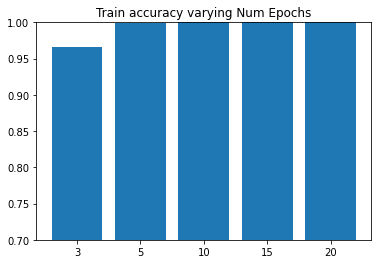

In [352]:
plt.bar([str(i) for i in num_epochs], [i[-1] for i in train_acc])
plt.ylim(0.7,1)
plt.title("Train accuracy varying Num Epochs")

Text(0.5, 1.0, 'Val accuracy varying Num Epochs')

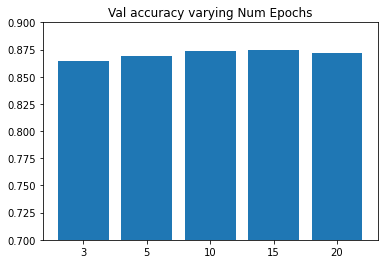

In [349]:
plt.bar([str(i) for i in num_epochs], [i[-1] for i in val_acc])
plt.ylim(0.7,0.9)
plt.title("Val accuracy varying Num Epochs")

(0.7, 0.9)

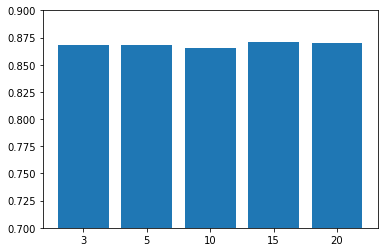

In [350]:
plt.bar([str(i) for i in num_epochs], test_acc)
plt.ylim(0.7,0.9)

In [351]:
test_acc

[0.8676999807357788,
 0.8676999807357788,
 0.8658000230789185,
 0.8705999851226807,
 0.870199978351593]

# BERT

In [353]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 16.3 MB/s 
     |████████████████████████████████| 7.6 MB 1.7 MB/s 
     |████████████████████████████████| 163 kB 72.2 MB/s 


In [368]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, InputExample, InputFeatures

## Build Model

In [369]:
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_143', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [370]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_143 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


## Data Processing

In [395]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, #Globally unique ID for bookkeeping, unused in this case
                                                           text_a=x[DATA_COLUMN],
                                                           text_b=None,
                                                           label=x[LABEL_COLUMN]), axis=1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                               text_a=x[DATA_COLUMN],
                                                               text_b=None,
                                                               label=x[LABEL_COLUMN]), axis=1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids,attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask,label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [396]:
DATA_COLUMN = 'cleaned_review'
LABEL_COLUMN = 'sentiment'
train_InputExamples, validation_InputExamples = convert_data_to_examples(test_set, val_set, DATA_COLUMN, LABEL_COLUMN)

In [397]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32)
#.repeat(2)
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

## Train the model

In [386]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sc_accuracy', patience=2, restore_best_weights=True)

In [398]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-8, clipnorm=1.0), #lr=3e-5, eps=01e-8
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('sc_accuracy')]
)

history = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data,
    callbacks=[callback],
)

Epoch 1/5
313/313 [==============================] - 187s 553ms/step - loss: 0.4046 - sc_accuracy: 0.8092 - val_loss: 0.3124 - val_sc_accuracy: 0.8707
Epoch 2/5
313/313 [==============================] - 171s 547ms/step - loss: 0.2537 - sc_accuracy: 0.8983 - val_loss: 0.3399 - val_sc_accuracy: 0.8611
Epoch 3/5
313/313 [==============================] - 171s 546ms/step - loss: 0.1558 - sc_accuracy: 0.9428 - val_loss: 0.3744 - val_sc_accuracy: 0.8637


In [399]:
import os
saved_model = "bert_saved_model"
os.makedirs(saved_model, exist_ok=True)
model.save(saved_model)

## Test the model

In [401]:
def convert_test_data_to_examples(data, DATA_COLUMN, LABEL_COLUMN): 

  data_InputExamples = data.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                         text_a=x[DATA_COLUMN],
                                                         text_b=None,
                                                         label=x[LABEL_COLUMN]), axis=1)
  
  return data_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')

In [402]:
test_InputExamples = convert_test_data_to_examples(test_set, DATA_COLUMN, LABEL_COLUMN)
test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

In [403]:
y_pred = model.predict(test_data)
tf_predictions = tf.nn.softmax(y_pred[0], axis=-1)
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()

313/313 [==============================] - 45s 138ms/step


In [404]:
print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4961
           1       0.89      0.94      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



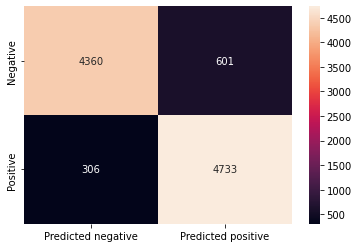

In [406]:
sns.heatmap(confusion_matrix(y_test, label), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Stacked Ensemble

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

In [ ]:
# save our base models
cnn_model.save('cnn_model.h5')
model.save('bilstm_model.h5')

Define our stacking model

In [ ]:
fileNames = ['cnn_model.h5','bilstm_model.h5'] # replace this with model file paths
from keras.models import load_model
from numpy import dstack
def load_all_models():
  all_models = []
  for file in fileNames:
    all_models.append(load_model(file))
  return all_models

In [ ]:
def stacked_dataset(members, inputX):
  stackX = None
  for model in members:
    # make prediction
    if isinstance(model, Sequential):
      yhat = model.predict(inputX, verbose=1)
    else:
      yhat = model.predict(inputX)
      yhat = np.reshape(yhat, (-1, 1))
    # stack predictions into [rows, members, probabilities]
    if stackX is None:
      stackX = yhat #
    else:
      stackX = dstack((stackX, yhat))
  # flatten predictions to [rows, members x probabilities]
  stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
  return stackX

In [ ]:
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit the meta learner
	model = LinearSVC() #meta learner
	model.fit(stackedX, inputy)
	return model

In [ ]:
members = load_all_models()
members.append(LinearSVC().fit(X_train, y_train))
members.append(LogisticRegression().fit(X_train, y_train))


14000/14000 [==============================] - 63s 4ms/step


TypeError: ignored

In [ ]:
stacked_model = fit_stacked_model(members, X_train, y_train)

14000/14000 [==============================] - 65s 5ms/step


In [ ]:
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [ ]:
y_pred = stacked_prediction(members, stacked_model, X_test)

1188/1188 [==============================] - 8s 6ms/step


In [ ]:
y_pred = members[3].predict(X_test)

              precision    recall  f1-score   support

           0       0.58      0.41      0.48     19000
           1       0.54      0.70      0.61     19000

    accuracy                           0.56     38000
   macro avg       0.56      0.56      0.55     38000
weighted avg       0.56      0.56      0.55     38000



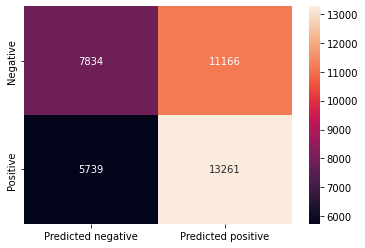

In [ ]:
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3), max_features=10000)
tfidf_features_train = vectorizer.fit_transform(train_set['cleaned_review'])
tfidf_features_test = vectorizer.transform(test_df['cleaned_review'])

KeyboardInterrupt: ignored

In [ ]:
test_model = LogisticRegression.fit(tfidf_features_train, y_train)
y_pred = test_model.predict(tfidf_features_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])